In [1]:
import xarray as xr
import numpy as np
from portfolio import Portfolio
from visualization.trading_stat import bear_market_suite

random_state = 42


In [2]:
base_ds = xr.open_dataset('../../data/nc_2round/base.nc')
fundamental_v0_ds = xr.open_dataset('../../data/nc_2round/fundamental_v0.nc')
market_ds = xr.open_dataset('../../data/nc_2round/market_brief.nc')

ds = xr.merge([base_ds, fundamental_v0_ds, market_ds])


In [3]:
## adding intraday feature
ds['close_moving_5_ratio'] = ds['close_0'] / ds['close_0'].rolling(day=5).mean()
ds['close_moving_20_ratio'] = ds['close_0'] / ds['close_0'].rolling(day=20).mean()


In [4]:
class PEMAPortfolio(Portfolio):
    def __init__(self):
        super().__init__(1, 'pe_10_20')

    def initialize(self, X, y):
        pass

    def train(self, X, y):
        pass

    def construct(self, X):
        current_day = X.day.max().item()
        X_ = X.sel(day=[current_day])
        pe = X_.pe
        good_company = (pe > 0) & (pe < 15)
        good_trend = X_['close_moving_5_ratio'] < X_['close_moving_20_ratio']
        good = good_trend & good_company
        market_pe = pe.median().item()
        investment = np.where(good, pe**(-5), 0)
        s = max(1e-6, investment.sum())
        y = investment / s
        propose = y * min(50 / market_pe, 1)
        propose[propose < 0.01] = 0
        # print(current_day, np.where(propose > 0), propose[np.where(propose > 0)])
        return propose


Now testing period (80, 200):


  0%|          | 0/121 [00:00<?, ?it/s]

Summary of scores:
1. APR: 26.4364%
2. Sharpe: 1.1097
3. Maximum drawdown: 0.1309
4. Median number of traded instruments: 0.0
Now testing period (640, 1000):


  0%|          | 0/361 [00:00<?, ?it/s]

Summary of scores:
1. APR: 7.7236%
2. Sharpe: 0.2193
3. Maximum drawdown: 0.1868
4. Median number of traded instruments: 3.0
Now testing period (1030, 1300):


  0%|          | 0/271 [00:00<?, ?it/s]

Summary of scores:
1. APR: -29.0976%
2. Sharpe: -0.9853
3. Maximum drawdown: 0.1506
4. Median number of traded instruments: 4.0


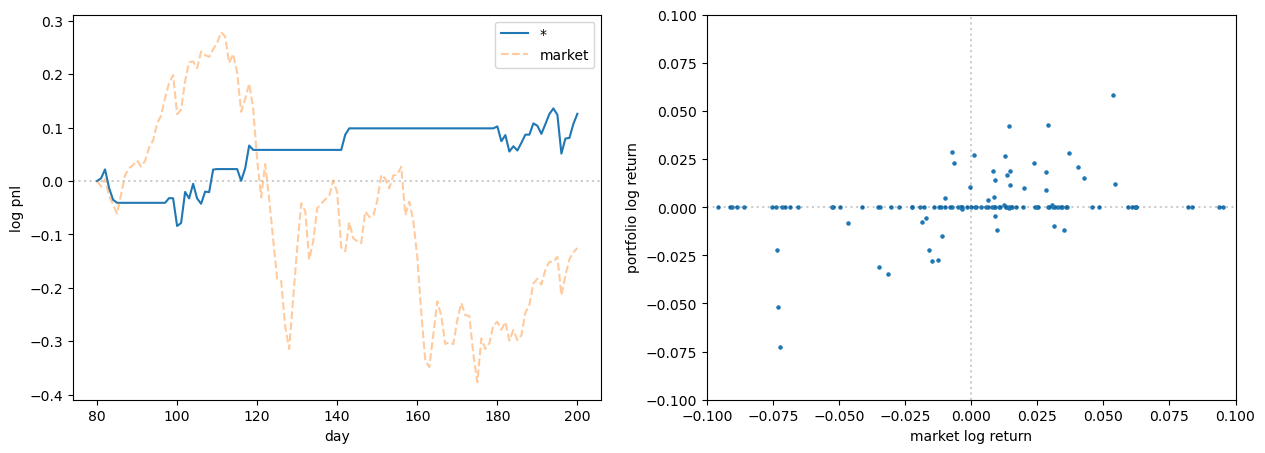

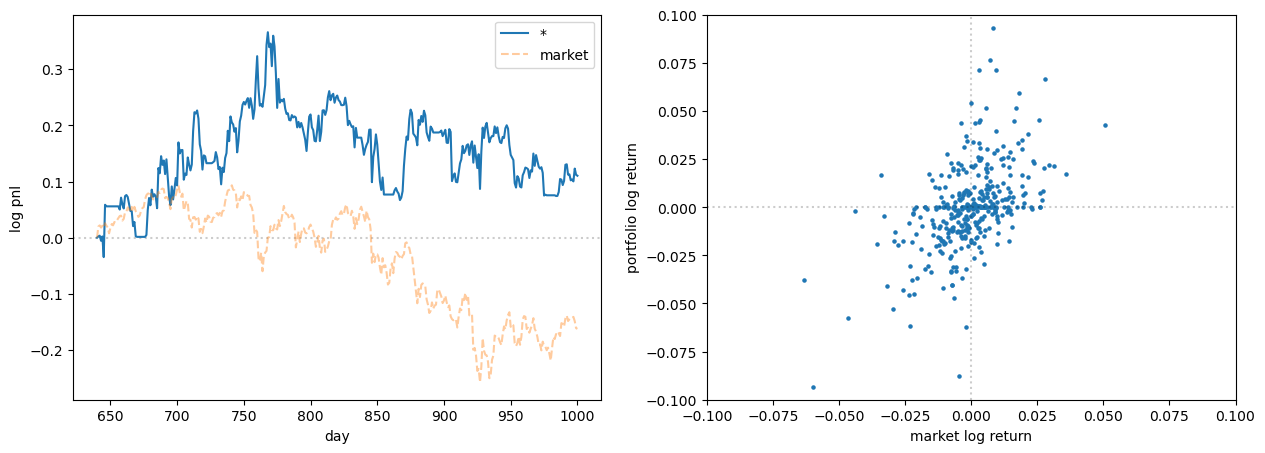

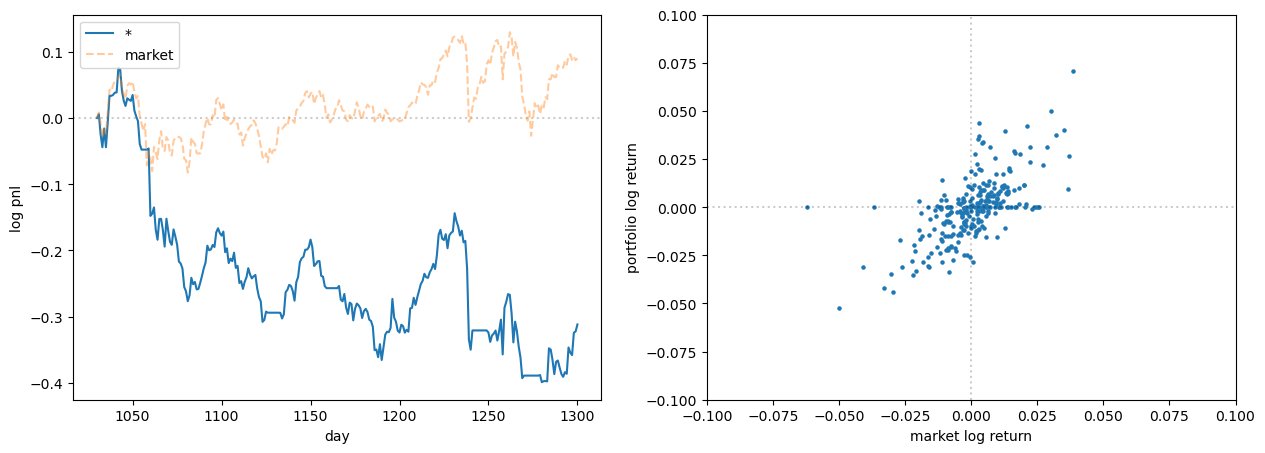

In [5]:
p = PEMAPortfolio()
bear_market_suite(p, ['pe', 'close_moving_5_ratio', 'close_moving_20_ratio'], ds, lookback_window=3, need_full_lookback=True)
